In [20]:
%reload_ext autoreload
%autoreload 2

In [33]:
import os
import sys
import seaborn as sns

import pandas as pd
from textblob import TextBlob
import matplotlib.pyplot as plt

In [ ]:
# Add parent directory to path to import modules from src
rpath = os.path.abspath('..')
if rpath not in sys.path:
    sys.path.insert(0, rpath)

from src.loader import SlackDataLoader
import src.utils as utils
from src.preprocessing import Preprocessing

In [6]:
# Initialize DataLoader
sdl = SlackDataLoader('../Anonymized_B6SlackExport_25Nov23/anonymized/')

In [7]:
# Group all messages by day since the start of the training
df = sdl.slack_channels_parser('../Anonymized_B6SlackExport_25Nov23/anonymized/')

In [9]:
df['msg_sent_time'] = pd.to_datetime(df['msg_sent_time'], unit='s').dt.date

In [25]:
# Concatenate messages for each day into one big text
df_concat = df.groupby('msg_sent_time')['msg_content'] \
    .agg(lambda messages: ' '.join(str(message) for message in messages) if pd.notna(messages.name) else '') \
    .reset_index(name='msg_content')

In [26]:
df_concat

,msg_sent_time,msg_content
0,2022-08-20,I am glad to make it to the week 1-4 program. ...
1,2022-08-21,"Hi all, looking forward to starting together, ..."
2,2022-08-22,<https://towardsdatascience.com/how-to-fill-mi...
3,2022-08-23,First you need to group by IMEI number then ap...
4,2022-08-24,I use vscode extension for notebook and it wor...
...,...,...
96,2022-11-26,<https://youtu.be/-DVyjdw4t9I|https://youtu.be...
97,2022-11-27,<https://resources.biginterview.com/interview-...
98,2022-11-30,"Hey <!channel>, can everyone work on deploymen..."
99,2022-12-12,"<!channel> Hi All, this version of Slack will ..."


In [12]:
df_concat.head()

,msg_sent_time,msg_content
0,2022-08-20,I am glad to make it to the week 1-4 program. ...
1,2022-08-21,"Hi all, looking forward to starting together, ..."
2,2022-08-22,<https://towardsdatascience.com/how-to-fill-mi...
3,2022-08-23,First you need to group by IMEI number then ap...
4,2022-08-24,I use vscode extension for notebook and it wor...


In [21]:
preprocess = Preprocessing(df_concat)

In [22]:
processed_df_concat = preprocess.preprocess_messages(df_concat,'msg_content')

In [34]:
def calculate_sentiment(row):
    try:
        blob = TextBlob(row['msg_content'])
        sentiment = blob.sentiment.polarity
        return {'Day': row.name, 'Sentiment': sentiment}
    except Exception as e:
        print(f"Error processing row {row.name}: {e}")
        return {'Day': row.name, 'Sentiment': None}

# Apply the function to each row and convert the result to a DataFrame
senti_df = processed_df_concat.apply(calculate_sentiment, axis=1).apply(pd.Series)


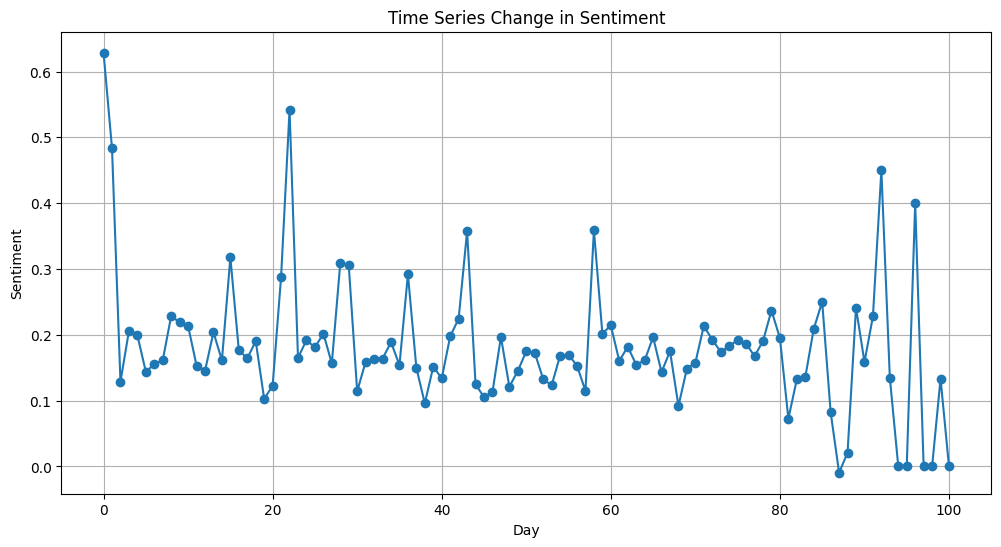

In [32]:
plt.figure(figsize=(12, 6))
plt.plot(senti_df['Day'], senti_df['Sentiment'], marker='o')
plt.title('Time Series Change in Sentiment')
plt.xlabel('Day')
plt.ylabel('Sentiment')
plt.grid(True)
plt.show()

#### The sentiment started on a positive note at day 0, but there was a substantial decrease until day 20. Despite occasional spikes in sentiment on certain days, an overall trend of diminishing sentiment persisted as the days advanced. Interestingly, sentiment seemed to rebound in the concluding days.